# Working with Real Data

In this tutorial we're going to download publicly available [1,000 Genomes Project](https://www.internationalgenome.org/) data and examine it with GRG. The goal is just to illustrate the ease with which you can work with such datasets. We also illustrate how to include population information in GRG for a real dataset.

**What is demonstrated:**

* Building a GRG from real data, including population information
* Using GRG matrix multiplication to calculate population-specific allele frequencies
* Using [grapp](https://github.com/aprilweilab/grapp) to filter information out of a GRG

**What you'll need:**

* Python dependencies "grapp", "seaborn": `pip install grapp seaborn`
* Command line tools "wget", "tabix": `sudo apt install wget tabix` (or your system's equivalent)

First, download the data. This can take 10-15 minutes, depending on your internet connection (the file is roughly 425MB)

In [1]:
%%bash

REMOTE_FILE="https://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000G_2504_high_coverage/working/20220422_3202_phased_SNV_INDEL_SV/1kGP_high_coverage_Illumina.chr22.filtered.SNV_INDEL_SV_phased_panel.vcf.gz"

if [[ ! -e kgp.chr22.vcf.gz ]]; then
    wget ${REMOTE_FILE} --progress=dot:mega -O kgp.chr22.vcf.gz
    tabix kgp.chr22.vcf.gz
fi

echo "Size of input file:"
du -hs kgp.chr22.vcf.gz

Size of input file:
426M	kgp.chr22.vcf.gz


## Build the GRG

GRG can be built from either [IGD](IGDToGRG.html) or directly from `.vcf.gz`. IGD is generally smaller and faster than VCF, so if you want to manipulate this data repeatedly (outside of GRG), then convert to IGD first. Otherwise, you can just do a one-time conversion from `.vcf.gz` to GRG.

We'll just convert from the VCF file. Before we do that, let's prepare information that maps each sample in the dataset to a population label, based on metadata provided from the 1,000 Genomes Project.

For population information, GRG needs a tab-separated file with a header. We construct the GRG with the filename and the names of two columns: the column containing the sample identifier (individual ID), and the column containing the population label.

1,000 Genomes data has both "population" and "super-population" labels in [their data browser](https://www.internationalgenome.org/data-portal/sample). We'll use the "population" labels since they are easier to download from the FTP site.

In [2]:
%%bash

if [[ ! -e 1000G_2504_high_coverage.sequence.index ]]; then
  # Two files: one for the original 2504 samples, and one for the additional 698 samples.
  wget https://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000G_2504_high_coverage/1000G_2504_high_coverage.sequence.index --progress=dot:mega
  wget https://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000G_2504_high_coverage/1000G_698_related_high_coverage.sequence.index --progress=dot:mega
fi

# Combine the two files into a single metadata file
cat 1000G_2504_high_coverage.sequence.index 1000G_698_related_high_coverage.sequence.index > kgp.combined_metadata.tsv

# Show the format
head -n 25 kgp.combined_metadata.tsv

--2026-02-06 12:31:56--  https://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000G_2504_high_coverage/1000G_2504_high_coverage.sequence.index
Resolving ftp.1000genomes.ebi.ac.uk (ftp.1000genomes.ebi.ac.uk)... 193.62.193.167
Connecting to ftp.1000genomes.ebi.ac.uk (ftp.1000genomes.ebi.ac.uk)|193.62.193.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 982480 (959K)
Saving to: ‘1000G_2504_high_coverage.sequence.index’

     0K ........ ......                                      100% 1.70M=0.5s

2026-02-06 12:31:57 (1.70 MB/s) - ‘1000G_2504_high_coverage.sequence.index’ saved [982480/982480]

--2026-02-06 12:31:57--  https://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000G_2504_high_coverage/1000G_698_related_high_coverage.sequence.index
Resolving ftp.1000genomes.ebi.ac.uk (ftp.1000genomes.ebi.ac.uk)... 193.62.193.167
Connecting to ftp.1000genomes.ebi.ac.uk (ftp.1000genomes.ebi.ac.uk)|193.62.193.167|:443... connected.
HTTP request sent, awaiti

##FileDate=20190503
##ENA_FILE_PATH=path to ENA file on ENA ftp site
##MD5=md5sum of file
##RUN_ID=SRA/ERA run accession
##STUDY_ID=SRA/ERA study accession
##STUDY_NAME=Name of study
##CENTER_NAME=Submission centre name
##SUBMISSION_ID=SRA/ERA submission accession
##SUBMISSION_DATE=Date sequence submitted, YYYY-MM-DD
##SAMPLE_ID=SRA/ERA sample accession
##SAMPLE_NAME=Sample name
##POPULATION=Sample population. Further information may be available with the data collection.
##EXPERIMENT_ID=Experiment accession
##INSTRUMENT_PLATFORM=Type of sequencing machine
##INSTRUMENT_MODEL=Model of sequencing machine
##LIBRARY_NAME=Library name
##RUN_NAME=Name of machine run
##INSERT_SIZE=Submitter specifed insert size/paired nominal length
##LIBRARY_LAYOUT=Library layout, this can be either PAIRED or SINGLE
##PAIRED_FASTQ=Name of mate pair file if exists (Runs with failed mates will have a library layout of PAIRED but no paired fastq file)
##READ_COUNT=Read count for the file
##BASE_COUNT=Basepair c

The file is a bit messy for GRG to try to use as is (especially since we concatenated the two files without removing the headers). So below we use some Python code to make it cleaner.

In [3]:
# List of (sample, population) pairs that we will output for use with GRG
sample_pops = []
with open("kgp.combined_metadata.tsv") as f:
    for line in f:
        line = line.rstrip("\n").rstrip("\r")
        # Skip comments
        if line.startswith("#"):
            continue
        data = line.split("\t")
        sample_pops.append( (data[9].strip(), data[10].strip()) )

with open("kgp.popmap.tsv", "w") as fout:
    fout.write("SAMPLE\tPOPULATION\n")  # Header
    fout.write("\n".join(["\t".join(s) for s in sample_pops]))

Now we can use the `--population-ids` flag to `grg construct` to incorporate this information in the GRG. This is mostly a convenience, we could just create the GRG without doing any of this population mapping.

The argument `"kgp.popmap.tsv:SAMPLE:POPULATION"` can be interpreted as `<filename>:<column with sample IDs>:<column with population labels>`.

Building this GRG takes about 4 minutes (with 4 threads) on my laptop.

In [4]:
%%bash

if [[ ! -e kgp.chr22.grg ]]; then
    grg construct -j 4 --population-ids "kgp.popmap.tsv:SAMPLE:POPULATION" kgp.chr22.vcf.gz -o kgp.chr22.grg
fi

Will not count variants in VCF files (too slow)
Could not count number of variants in kgp.chr22.vcf.gz. Using the default of 100 (use --parts to override).
Processing input file in 100 parts.
Auto-calculating number of trees per part.
Converting segments of input data to graphs
100%|██████████| 100/100 [04:54<00:00,  2.94s/it]
Merging...


=== GRG Statistics ===
Nodes: 2460735
Edges: 21442726
Samples: 6404
Mutations: 1066557
Ploidy: 2
Phased: true
Populations: 26
Range of mutations: 10519265 - 50808015
Specified range: 0 - 50818469
Wrote simplified GRG with:
  Nodes: 2460735
  Edges: 21442726
Wrote GRG to kgp.chr22.grg


## Examine GRG and allele frequencies

Now we can load the GRG and examine the information in it. As an example, lets compute the allele frequencies for just a few of the populations that have a large number of samples (more than 200 haplotypes) in the dataset. We'll compute these per-population and then display them.

For more complex computations on GRG, see [LinearOperators](LinearOperators.html), [PCA](PCA.html), or [GWAS](GWAS.html).

In [5]:
import pygrgl

grg = pygrgl.load_immutable_grg("kgp.chr22.grg", load_up_edges=False)

Something really simple we can do is look at the individual identifiers for each individual in the GRG. Not all GRGs have individual IDs: only if the original data had the IDs.
Here we just show the first and last individual.

In [6]:
print(f"First: {grg.get_individual_id(0)}")
print(f"Last: {grg.get_individual_id(grg.num_individuals - 1)}")

First: HG00096
Last: NA21144


We want to use [GRG matrix multiplication](https://grgl.readthedocs.io/en/stable/python_api.html#pygrgl.matmul) later on to compute the per-population allele frequencies. So we will:
* Find all $K$ populations with at least 200 haplotypes
* Create a $K \times 2N$ matrix (where $N$ is the number of diploid individuals) $A$ that represents our labeled samples
* If haplotype sample $i$ has population label $j$, then $A_{j, i} = 1$
* Given our (haploid) genotype matrix $X$ (as represented by the GRG), we can get the population specific allele counts via $A \times X$

In [7]:
from collections import defaultdict
import numpy

# Find populations with at least 100 haplotypes
labels = grg.get_populations()
pop_mapping = defaultdict(list)
for sample in range(grg.num_samples):
    pop_label = labels[grg.get_population_id(sample)]
    pop_mapping[pop_label].append(sample)

# Get labels and samples for populations exceeding our threshold
K_pops = list(filter(lambda item: len(item[1]) >= 200, pop_mapping.items()))

# Create the matrix
K = len(K_pops)
A = numpy.zeros( (K, grg.num_samples), dtype=numpy.int32 )

# Populate the matrix
for j, (pop_label, sample_list) in enumerate(K_pops):
    print(f"{pop_label} has {len(sample_list)} haplotypes")
    A[j, sample_list] = 1

CHS has 326 haplotypes
PUR has 278 haplotypes
CLM has 264 haplotypes
IBS has 314 haplotypes
PEL has 244 haplotypes
PJL has 292 haplotypes
KHV has 244 haplotypes
ACB has 232 haplotypes
GWD has 356 haplotypes
ESN has 298 haplotypes
BEB has 262 haplotypes
STU has 228 haplotypes
ITU has 214 haplotypes
CEU has 358 haplotypes
YRI has 356 haplotypes
CHB has 206 haplotypes
JPT has 208 haplotypes
TSI has 214 haplotypes
GIH has 206 haplotypes


Now we compute the allele counts. The frequency will just be dividing the counts by $N_j$, the number of haploptypes in each population.

We're going to use [pygrgl.matmul](https://grgl.readthedocs.io/en/stable/python_api.html#pygrgl.matmul) to do the work for us. _Notice_: we could also do our own graph traversal to compute these values, but `matmul()` is much faster (it does the traversal with optimized C++ code).

In [8]:
N = [len(sample_list) for pop_label, sample_list in K_pops]

# The "direction" tells us whether we are summing values from the leaves-to-roots (UP) or roots-to-leaves (DOWN).
# These are equivalent to multiplication against X or X^T.
# Here we have an input that is in terms of _samples_, which are the leaves, so we need to start at the samples
# and sum the values until we reach the mutations (UP).
allele_counts = pygrgl.matmul(grg, A, pygrgl.TraversalDirection.UP)

frequencies = allele_counts / numpy.array([N]).T

We'll pick the column from the data that has an above average sum and plot it.

Text(0.5, 0, '')

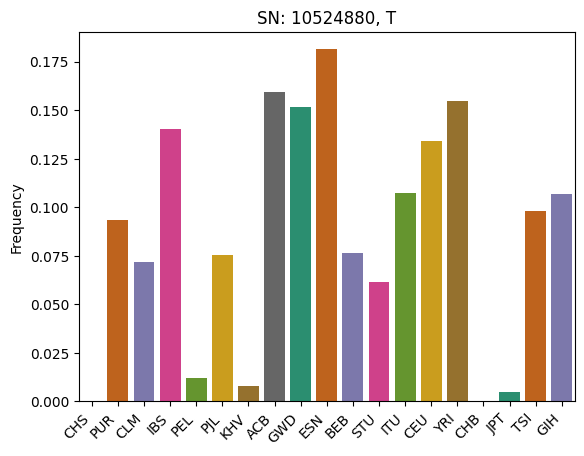

In [9]:
import seaborn
import pandas

# Sum by column
total_snp_freqs = numpy.sum(frequencies[:, ], axis=0)

# Find the maximum column sum values
avg = numpy.mean(total_snp_freqs)

# Get the first index that has the max value
snp_index = numpy.where(total_snp_freqs >= avg)[0][0]
mutation = grg.get_mutation_by_id(snp_index)             # Get the Mutation object

# Now plot the frequencies at that index
df = pandas.DataFrame({
    "SNP": [snp_index] * K,
    "Frequency": frequencies[:, snp_index],
    "Pop Label": [label for label, smp in K_pops],
})
ax = seaborn.barplot(data=df, x="Pop Label", y="Frequency", hue="Pop Label", palette="Dark2")
ax.set_title(f"SN: {mutation.position}, {mutation.allele}")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_xlabel(None)

## Filter the GRG

Now we illustrate the types of filtering that are available. At the basic level GRG can be filtered in two ways:
1. By removing a subset of samples.
2. By removing a subset of mutations.
If you want to do both, then you need to do it sequentially: e.g., first remove mutations and then samples (or vise versa).

The core library for filtering is [pygrgl.save_subset](https://grgl.readthedocs.io/en/stable/python_api.html#pygrgl.save_subset), which is very flexible and useful for calling from Python code.

However, here we are going to demonstrate the filtering available in the [grapp command line](https://github.com/aprilweilab/grapp/blob/main/README.md), which implements a bunch of common filtering scenarios for you (and calls `save_subset()` under the hood).

## Filter by sample

First, we'll filter the GRG down to just the samples that we used in our plot above. We'll use `grapp filter --hap-samples <filename>` to do this.

In our case, we know that we are actually filtering by individuals; even though the population information is stored at the haplotype level, the way we generated the GRG means that we will only have pairs of haplotypes that belond to individuals. In other words: the haplotype-to-diploid mapping is _maintained_ by this filter.

In [10]:
# Save our samples to a list
all_samples = []
for pop_label, sample_list in K_pops:
    all_samples.extend(sample_list)

with open("haplotypes.txt", "w") as fout:
    fout.write("\n".join(map(str, all_samples)))

print(f"Wrote {len(all_samples)} samples to haplotypes.txt")

Wrote 5100 samples to haplotypes.txt


In [11]:
%%bash
# Filter the GRG. This should be pretty fast (seconds).
grapp filter --hap-samples haplotypes.txt kgp.chr22.grg kgp.chr22.hap_filtered.grg

grg process stats kgp.chr22.hap_filtered.grg

Keeping 5100 haplotypes


Construction took 158 ms


=== GRG Statistics ===
Nodes: 2219044
Edges: 18011864
Samples: 5100
Mutations: 1066557
Ploidy: 2
Phased: true
Populations: 26
Range of mutations: 10519265 - 50808015
Specified range: 0 - 0


Notice that `Ploidy: 2` above was retained: this is because we filtered the haplotypes in a way that kept their pairing between diploid and haplotype. If we filter a GRG by haplotype and do not maintain this (e.g., if we keep the odd-numbered haplotypes only) then the GRG will become `Ploidy: 1`.

Another way to do the above filtering is to just specify what populations we want! We can use `grapp filter --populations` for that. For both of these commands, you can either specify a filename or a comma-separated list of items to keep.

In [12]:
%%bash
# Filter the GRG. This should be pretty fast (seconds).
grapp filter --populations "CHS,PUR,CLM,IBS,PEL,PJL,KHV,ACB,GWD,ESN,BEB,STU,ITU,CEU,YRI,CHB,JPT,TSI,GIH" kgp.chr22.grg kgp.chr22.pop_filtered.grg

grg process stats kgp.chr22.pop_filtered.grg

Keeping 5100 haplotypes


Construction took 144 ms


=== GRG Statistics ===
Nodes: 2219044
Edges: 18011864
Samples: 5100
Mutations: 1066557
Ploidy: 2
Phased: true
Populations: 26
Range of mutations: 10519265 - 50808015
Specified range: 0 - 0


## Filter by Mutation

There are a bunch of options for filtering by Mutations.
```
mutation filters:
  -r RANGE, --range RANGE
                        Keep only the variants within the given range, in base pairs. Example: "lower-upper", where both are integers and lower is inclusive, upper is exclusive.
  -c MIN_AC, --min-ac MIN_AC
                        Minimum allele count to keep. All Mutations with count below this value will be dropped
  -C MAX_AC, --max-ac MAX_AC
                        Maximum allele count to keep. All Mutations with count above this value will be dropped
  -q MIN_AF, --min-af MIN_AF
                        Minimum allele frequency to keep. All Mutations with frequency below this value will be dropped
  -Q MAX_AF, --max-af MAX_AF
                        Maximum allele frequency to keep. All Mutations with frequency above this value will be dropped
```

These filters can be combined together in a single command. Here we'll illustrate keeping only mutations with the range `20000000-25000000` that have an allele count of at least 20.

In [13]:
%%bash
# Filter the GRG. This should be pretty fast (seconds).
grapp filter -r "20000000-25000000" -c 20 kgp.chr22.pop_filtered.grg kgp.chr22.mut_filtered.grg

grg process stats kgp.chr22.mut_filtered.grg

Construction took 10 ms


=== GRG Statistics ===
Nodes: 274295
Edges: 2476134
Samples: 5100
Mutations: 47945
Ploidy: 2
Phased: true
Populations: 26
Range of mutations: 20000241 - 24999768
Specified range: 20000000 - 25000000


In [14]:
# Lets load the graph and check the minimum allele counts!
from grapp.util.simple import allele_counts

smaller_grg = pygrgl.load_immutable_grg("kgp.chr22.mut_filtered.grg")
mut_counts = allele_counts(smaller_grg)

print(f"Minimum allele count: {numpy.min(mut_counts)}")

Minimum allele count: 20


## Related Topics

* More specific applications for GRG to real data are [GWAS](GWAS.html), [PCA](PCA.html).
* Documentation links:
  * [pygrgl](https://grgl.readthedocs.io/en/stable/python_api.html): The full Python API for GRGL, the low-level operations you can perform on a GRG.
  * [grapp.util](https://grapp.readthedocs.io/en/latest/grapp.html#filtering-export-etc): The Python APIs for utility functions, like counting alleles, filtering, etc.